## Clustering asthma-related papers in CORD-19 dataset

### Introduction
The goal of this project is to explore research topics in asthma and coronviruses. What are the most popular topics the research community is focused on, before and after the COVID-19 outbreak? Are the areas of interest around asthma and coronaviruses the same before and after the appearance of SARS-CoV-2? 

In this project, I use Natural Language Processing (NLP) techniques in Python, to explore topics of research between asthma and coronaviruses before the identification of SARS-CoV-2, but also after the outbreak of the pandemic. The analysis is based on clustering scientific publications, in order to create groups of papers with similar topics. Two groups of clusters are created, one for papers published before and one for papers published after the COVID-19 outbreak. For the two periods of times, clustering aims at identifying popular research topics and finding potential gaps in research between asthma and the new coronavirus.

More details about the motivation and the scientific background of this data analysis can be found in my Medium article:


### Data
In response to the COVID-19 pandemic a large database, the COVID-19 Open Research Dataset (CORD-19), was created and has been made publicly available. CORD-19 is a resource of hundreds of thousands scholarly articles, about COVID-19, SARS-CoV-2, and related coronaviruses: https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge

### Collecting and Preprocessing Data

From this large database, I kept only those papers where the word "asthma" appears at least once in the abstract.

I went through the following text preprocessing steps, using NLTK and SpaCy:
- Removal of stop words
- Removal of non-English publications

Using their publication date, I divided the papers into those published before the outbreak of the pandemic (December 2019) and those published after. For the two groups of papers I applied:
- Tokenization
- Stemming
- Use of the Scikit-learn's Tfidf Vectorizer to transform tokens into a matrix of TF-IDF features
- Application of the KMeans algorithm for Clustering
- Application of the PCA algorithm for dimensionality reduction and clusters' visualization

*Note: This data analysis was performed in February 2021 and doesn't take into account potential databases updates.*


### Loading libraries

In [1]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn import preprocessing
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image

In [2]:
pd.options.display.max_colwidth = 200

In [3]:
import nltk
import string
from nltk.stem import PorterStemmer
from sklearn.cluster import KMeans
from langdetect import detect

In [4]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

from yellowbrick.cluster import KElbowVisualizer

In [5]:
import pickle

In [6]:
import plotly.express as px
import plotly.io as pio
pio.renderers
import plotly.graph_objects as go

import seaborn as sns
from wordcloud import WordCloud, ImageColorGenerator


In [7]:
from nltk.corpus import stopwords
stop_words = stopwords.words("english")


In [8]:
spacy_stop_words = ['whence', 'here', 'show', 'were', 'why', 'n’t', 'the', 'whereupon', 'not', 'more', 'how', 'eight', 'indeed', 'i', 'only', 'via', 'nine', 're', 'themselves', 'almost', 'to', 'already', 'front', 'least', 'becomes', 'thereby', 'doing', 'her', 'together', 'be', 'often', 'then', 'quite', 'less', 'many', 'they', 'ourselves', 'take', 'its', 'yours', 'each', 'would', 'may', 'namely', 'do', 'whose', 'whether', 'side', 'both', 'what', 'between', 'toward', 'our', 'whereby', "'m", 'formerly', 'myself', 'had', 'really', 'call', 'keep', "'re", 'hereupon', 'can', 'their', 'eleven', '’m', 'even', 'around', 'twenty', 'mostly', 'did', 'at', 'an', 'seems', 'serious', 'against', "n't", 'except', 'has', 'five', 'he', 'last', '‘ve', 'because', 'we', 'himself', 'yet', 'something', 'somehow', '‘m', 'towards', 'his', 'six', 'anywhere', 'us', '‘d', 'thru', 'thus', 'which', 'everything', 'become', 'herein', 'one', 'in', 'although', 'sometime', 'give', 'cannot', 'besides', 'across', 'noone', 'ever', 'that', 'over', 'among', 'during', 'however', 'when', 'sometimes', 'still', 'seemed', 'get', "'ve", 'him', 'with', 'part', 'beyond', 'everyone', 'same', 'this', 'latterly', 'no', 'regarding', 'elsewhere', 'others', 'moreover', 'else', 'back', 'alone', 'somewhere', 'are', 'will', 'beforehand', 'ten', 'very', 'most', 'three', 'former', '’re', 'otherwise', 'several', 'also', 'whatever', 'am', 'becoming', 'beside', '’s', 'nothing', 'some', 'since', 'thence', 'anyway', 'out', 'up', 'well', 'it', 'various', 'four', 'top', '‘s', 'than', 'under', 'might', 'could', 'by', 'too', 'and', 'whom', '‘ll', 'say', 'therefore', "'s", 'other', 'throughout', 'became', 'your', 'put', 'per', "'ll", 'fifteen', 'must', 'before', 'whenever', 'anyone', 'without', 'does', 'was', 'where', 'thereafter', "'d", 'another', 'yourselves', 'n‘t', 'see', 'go', 'wherever', 'just', 'seeming', 'hence', 'full', 'whereafter', 'bottom', 'whole', 'own', 'empty', 'due', 'behind', 'while', 'onto', 'wherein', 'off', 'again', 'a', 'two', 'above', 'therein', 'sixty', 'those', 'whereas', 'using', 'latter', 'used', 'my', 'herself', 'hers', 'or', 'neither', 'forty', 'thereupon', 'now', 'after', 'yourself', 'whither', 'rather', 'once', 'from', 'until', 'anything', 'few', 'into', 'such', 'being', 'make', 'mine', 'please', 'along', 'hundred', 'should', 'below', 'third', 'unless', 'upon', 'perhaps', 'ours', 'but', 'never', 'whoever', 'fifty', 'any', 'all', 'nobody', 'there', 'have', 'anyhow', 'of', 'seem', 'down', 'is', 'every', '’ll', 'much', 'none', 'further', 'me', 'who', 'nevertheless', 'about', 'everywhere', 'name', 'enough', '’d', 'next', 'meanwhile', 'though', 'through', 'on', 'first', 'been', 'hereby', 'if', 'move', 'so', 'either', 'amongst', 'for', 'twelve', 'nor', 'she', 'always', 'these', 'as', '’ve', 'amount', '‘re', 'someone', 'afterwards', 'you', 'nowhere', 'itself', 'done', 'hereafter', 'within', 'made', 'ca', 'them']

In [9]:
# extending the list of stopwords taken into account
stop_words.extend(spacy_stop_words)

### Data overview

In [10]:
# Loading the csv file to a pandas dataframe, to have a look at the papers' metadata:
asthma_df = pd.read_csv("asthma_data.csv")
asthma_df.head()

gitcord_uid                                       sha source_x  \
0    qva0jt86  4ba79e54ecf81b30b56461a6aec2094eaf7b7f06      PMC   
1    chz8luni  d68d71553d3a31381c0c3851351f912a9a7be1c9      PMC   
2    3zh8jmc2  fe2000f280297c40bc53ce95d703a9ca6aac19fd      PMC   
3    7p3b6tyf  3ccbd07ee1865e4f2afffdb6cc8b6039ab605ee7      PMC   
4    xrsyj1tc  fa88fbb8716e5fca7d513bcb5a0a608456a59205      PMC   

                                                                                                                                                                                                     title  \
0                                                                                                                                              Relevance of human metapneumovirus in exacerbations of COPD   
1                                                                                                      Surfactant therapy for acute respiratory failure in children: a systematic review and meta-analysis   
2                                                                               Differential Regulation of Type I Interferon and Epidermal Growth Factor Pathways by a Human Respirovirus Virulence Factor   
3  The Tennessee Children's Respiratory Initiative: Objectives, design and recruitment results of a prospective cohort study investigating infant viral respiratory illness and the development of asth...   
4                                                                                                         Analysing the eosinophil cationic protein - a clue to the function of the eosinophil granulocyte   

                                doi       pmcid   pubmed_id license  \
0           10.1186/1465-9921-6-150  PMC1334186  16371156.0   cc-by   
1                    10.1186/cc5944  PMC2206432  17573963.0   cc-by   
2      10.1371/journal.ppat.1000587  PMC2736567  19806178.0   cc-by   
3  10.1111/j.1440-1843.2010.01743.x  PMC2992986  20409023.0   no-cc   
4           10.1186/1465-9921-12-10  PMC3030543  21235798.0   cc-by   

                                                                                                                                                                                                  abstract  \
0  BACKGROUND AND METHODS: Human metapneumovirus (hMPV) is a recently discovered respiratory virus associated with bronchiolitis, pneumonia, croup and exacerbations of asthma. Since respiratory virus...   
1  INTRODUCTION: Exogenous surfactant is used to treat acute respiratory failure in children, although the benefits and harms in this setting are not clear. The objective of the present systematic re...   
2  A number of paramyxoviruses are responsible for acute respiratory infections in children, elderly and immuno-compromised individuals, resulting in airway inflammation and exacerbation of chronic d...   
3  Background and objective: The ‘attack rate’ of asthma following viral lower respiratory tract infections (LRTI) is about 3–4 fold higher than that of the general population; however, the majority ...   
4  Eosinophil granulocytes reside in respiratory mucosa including lungs, in the gastro-intestinal tract, and in lymphocyte associated organs, the thymus, lymph nodes and the spleen. In parasitic infe...   

  publish_time  ...      journal mag_id  who_covidence_id arxiv_id  \
0   2005-12-21  ...   Respir Res    NaN               NaN      NaN   
1   2007-06-15  ...    Crit Care    NaN               NaN      NaN   
2   2009-09-18  ...  PLoS Pathog    NaN               NaN      NaN   
3   2010-04-08  ...  Respirology    NaN               NaN      NaN   
4   2011-01-14  ...   Respir Res    NaN               NaN      NaN   

                                                           pdf_json_files  \
0  document_parses/pdf_json/4ba79e54ecf81b30b56461a6aec2094eaf7b7f06.json   
1  document_parses/pdf_json/d68d71553d3a31381c0c3851351f912a9a7be1c9.json   
2  document_parses/pdf_json/fe2000f28029

There are 2567 papers containing the word "asthma", among the coronavirus-related publications 

In [11]:
asthma_df.shape

(2567, 21)

In [12]:
# Use of langdetect google library to dect the language of the "abstract" column in our dataframe

asthma_df["lang_detect"] = asthma_df["abstract_lower"].apply(detect)

In [13]:
# As non-english papers occupy only a small percent of our total papers, they are excluded from the analysis

asthma_df["lang_detect"].value_counts()

en    2528
de      12
fr      11
es       9
ru       3
pt       2
nl       2
Name: lang_detect, dtype: int64

There are 2528 papers in total, written in english.

In [14]:
asthma_df = asthma_df.loc[asthma_df['lang_detect'] == "en"]
asthma_df.shape

(2528, 22)

I'd like to quickly vizualize the text of these papers, that's why I create a wordcloud where the most frequent words are represented by a bigger font! I'd like to give a shape to my image and use it as a cover for my article! What would it be?

In [15]:
virus_mask = np.array(Image.open("coronavirus_canvas.png"))

In [16]:
text = " ".join(ab for ab in asthma_df["abstract_lower"].tolist())

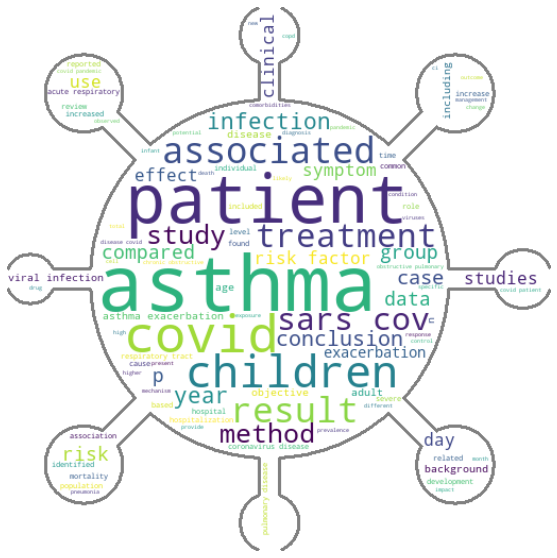

In [17]:
wc = WordCloud(background_color="white", max_words=100, mask=virus_mask,
               stopwords=stop_words, contour_width=3, contour_color='gray')

wc.generate(text)

wc.to_file("coronavirus_new.png")

plt.figure(figsize=[20,10])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

Let's go back to data processing!


Papers are divided between those published before the identification of the new coronavirus, SARS-CoV-2, and those published after. I pick December 2019 as the cut-off date. 

The dataset contains 1023 papers published before December 2019 and 1507 papers published on December 2019 and later.

In [18]:
asthma_before_covid = asthma_df.loc[asthma_df['publish_time']<"2019-12-01"].reset_index(drop=True)
asthma_before_covid.shape

(1020, 22)

In [19]:
asthma_after_covid = asthma_df.loc[asthma_df['publish_time']>="2019-12-01"].reset_index(drop=True)
asthma_after_covid.shape

(1508, 22)

Let's have a look at the number of the papers published, per month, since the covid outbreak. 

In [20]:
asthma_after_covid['publish_time_new'] =  pd.to_datetime(asthma_after_covid['publish_time'])

In [21]:
asthma_after_covid['publish_month_year'] = pd.to_datetime(asthma_after_covid['publish_time']).dt.to_period('M')
asthma_after_covid.head()

gitcord_uid                                       sha source_x  \
0    3ki0dzwb  71b8c50ee0e1f4e79e6618301b768befbf943a5d      PMC   
1    okc7wf4n  f4edbfd3e9a8b2d0d76378e6588a5971b070a4c9      PMC   
2    8lqjl0ee  1f6fa8e138abc1556e853c53dcce8f5e16007fcc      PMC   
3    vosu7y6j  6fa9233f054f4bbb31972e05c1478b0ec83ccc16      PMC   
4    yyw64g9w  8d634bba632c08e7d8e105a66dac4e0d813ab4e9      PMC   

                                                                                                                               title  \
0                 Inflammatory and microbiological associations with near-fatal asthma requiring extracorporeal membrane oxygenation   
1  Different effects of acetyl-CoA carboxylase inhibitor TOFA on airway inflammation and airway resistance in a mice model of asthma   
2                                   Risk of Readmission and Mortality Following Hospitalization with Hypercapnic Respiratory Failure   
3                                                                   Innate Type 2 Responses to Respiratory Syncytial Virus Infection   
4                       From Mouse to Man and Back: Closing the Correlation Gap between Imaging and Histopathology for Lung Diseases   

                           doi       pmcid   pubmed_id   license  \
0  10.1183/23120541.00267-2019  PMC6983494  32010717.0  cc-by-nc   
1   10.1007/s43440-019-00027-8  PMC7223088  32048254.0     no-cc   
2   10.1007/s00408-019-00300-w  PMC7223622  31828514.0     no-cc   
3            10.3390/v12050521  PMC7290766  32397226.0     cc-by   
4  10.3390/diagnostics10090636  PMC7554749  32859103.0     cc-by   

                                                                                                                                                                                                  abstract  \
0  Patients with near-fatal asthma requiring ECMO are more likely to be younger and female and are also likely to have positive viral and fungal isolates on bronchoalveolar lavage when compared to th...   
1  BACKGROUND AND OBJECTIVE: Acetyl CoA carboxylase (ACC) regulates the differentiation of Th1, Th2, Th17 cells and Treg cells, which play a critical role in airway inflammation of asthma. Here we in...   
2  PURPOSE: Hypercapnic respiratory failure (HRF) is a frequent cause of hospitalization and a common comorbidity in hospitalized patients. There are few studies addressing what factors might predict...   
3  Respiratory syncytial virus (RSV) is a common and contagious virus that results in acute respiratory tract infections in infants. In many cases, the symptoms of RSV remain mild, however, a subset ...   
4  Lung diseases such as fibrosis, asthma, cystic fibrosis, infection and cancer are life-threatening conditions that slowly deteriorate quality of life and for which our diagnostic power is high, bu...   

  publish_time  ... arxiv_id  \
0   2020-01-27  ...      NaN   
1   2020-01-08  ...      NaN   
2   2019-12-11  ...      NaN   
3   2020-05-08  ...      NaN   
4   2020-08-26  ...      NaN   

                                                           pdf_json_files  \
0  document_parses/pdf_json/71b8c50ee0e1f4e79e6618301b768befbf943a5d.json   
1  document_parses/pdf_json/f4edbfd3e9a8b2d0d76378e6588a5971b070a4c9.json   
2  document_parses/pdf_json/1f6fa8e138abc1556e853c53dcce8f5e16007fcc.json   
3  document_parses/pdf_json/6fa9233f054f4bbb31972e05c1478b0ec83ccc16.json   
4  document_parses/pdf_json/8d634bba632c08e7d8e105a66dac4e0d813ab4e9.json   

                                 pmc_json_files  \
0  document_parses/pmc_json/PMC6983494.xml.json   
1  document_parses/pmc_json/PMC7223088.xml.json   
2  document_parses/pmc_json/PMC7223622.xml.json   
3  document_parses/pmc_json/PMC7290766.xml.json   
4  document_parses/pmc_json/PMC7554749.xml.json   

                                                     url  s2_id  \
0  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6983494/    NaN   
1  https://www.ncbi.nlm.nih.gov/p

In [22]:
asthma_after_covid = asthma_after_covid.sort_values('publish_month_year')

In [23]:
dates = asthma_after_covid["publish_month_year"].value_counts()
dates_df = dates.to_frame().reset_index()

In [24]:
dates_df = dates_df.sort_values("index")

In [25]:
dates_df.rename(columns={"index": "date_published", "publish_month_year":"number of papers"})

date_published  number of papers
12        2019-12                10
0         2020-01               601
13        2020-02                 9
14        2020-03                 8
11        2020-04                19
8         2020-05                69
7         2020-06                74
3         2020-07                92
9         2020-08                60
4         2020-09                91
2         2020-10                96
6         2020-11                76
5         2020-12                77
1         2021-01               182
10        2021-02                43
15        2021-04                 1

The graph below illustrates the number of papers published through the last 12-14 months. However, we recognize that the two picks noticed in January 2020 and January 2021 are not completely accurate. As a certain number of papers had only the year (yyyy) mentioned as publication date, January 1st of that year (01/01/yyyy) is taken as their complete date.

As a result, we cannot draw a very accurate example of the distribution of publications through the months.

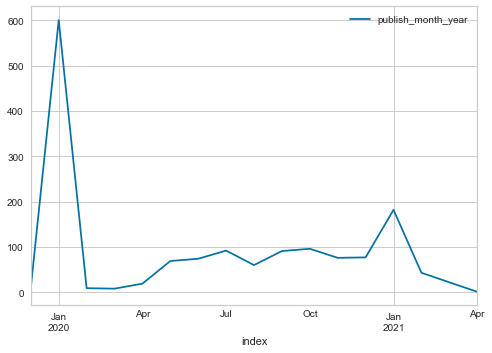

In [26]:
dates_df.plot(x ='index', y = 'publish_month_year')

## Clustering

### Before COVID-19

In [27]:
texts_before = asthma_before_covid["abstract_lower"].tolist()

In [28]:
def custom_tokenizer(str_input):
    
    stemmer = PorterStemmer()
    words = nltk.word_tokenize(str_input)
    words = [word for word in words if word.lower() not in stop_words]
    
    words = [word.replace('â¡', '') for word in words]
    words = [word.replace('â¢', '') for word in words]
    words = [word.replace('â£', '') for word in words]
       
    words = [''.join(c for c in word if c not in string.punctuation+'©±×≤≥●＜--“”→„') for word in words]
    words = [word for word in words if word not in ['‘', '’', '„']]
        
    words = [word for word in words if word]
    words = [word for word in words if not any(char.isdigit() for char in word)]
    
    words = [stemmer.stem(word) for word in words]
    words = [word for word in words if len(word)> 1]
    words = [word for word in words if "asthma" not in word]
    
        
    return words

In [29]:
vec_before = TfidfVectorizer(tokenizer=custom_tokenizer,
                             max_features=2000,
                      stop_words='english')

matrix_before = vec_before.fit_transform(texts_before)
df_before = pd.DataFrame(matrix_before.toarray(), columns=vec_before.get_feature_names())
df_before.head()

c:\users\katerina\appdata\local\programs\python\python37\lib\site-packages\sklearn\feature_extraction\text.py:386: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['cri', 'describ', 'sincer'] not in stop_words.



aa  abdelbaset  abil  abl  abnorm  absenc  absent  absolut  abstract  \
0  0.0         0.0   0.0  0.0     0.0     0.0     0.0      0.0       0.0   
1  0.0         0.0   0.0  0.0     0.0     0.0     0.0      0.0       0.0   
2  0.0         0.0   0.0  0.0     0.0     0.0     0.0      0.0       0.0   
3  0.0         0.0   0.0  0.0     0.0     0.0     0.0      0.0       0.0   
4  0.0         0.0   0.0  0.0     0.0     0.0     0.0      0.0       0.0   

   abuelmagd  ...  yoonseok  youn  young  younger  younghe  youngho   yr   yu  \
0        0.0  ...       0.0   0.0    0.0      0.0      0.0      0.0  0.0  0.0   
1        0.0  ...       0.0   0.0    0.0      0.0      0.0      0.0  0.0  0.0   
2        0.0  ...       0.0   0.0    0.0      0.0      0.0      0.0  0.0  0.0   
3        0.0  ...       0.0   0.0    0.0      0.0      0.0      0.0  0.0  0.0   
4        0.0  ...       0.0   0.0    0.0      0.0      0.0      0.0  0.0  0.0   

   yun  zhang  
0  0.0    0.0  
1  0.0    0.0  
2  0.0    0.0  
3  0.0    0.0  
4  0.0    0.0  

[5 rows x 2000 columns]

I use the "elbow" method for an estimation of the optimal number of clusters for the group of papers:
https://www.scikit-yb.org/en/latest/api/cluster/elbow.html

However, in the context of this analysis the results are not reproducible and different number of clusters is suggested by the model. For this reason, the method is not taken completely into account. 
The final number of clusters for each group of papers is chosen after running the code for different numbers of clusters and reviewing the clusters' content (papers' topics) every time.

For more information about the use of Kmeans in clustering: 
https://towardsdatascience.com/understanding-k-means-clustering-in-machine-learning-6a6e67336aa1

In [30]:
def vizualize_elbow(data, min_cluster=4, max_cluster=20):
    
    model = KMeans(random_state=2)
    visualizer = KElbowVisualizer(model, k=(min_cluster, max_cluster))

    visualizer.fit(data)
       
    return visualizer  

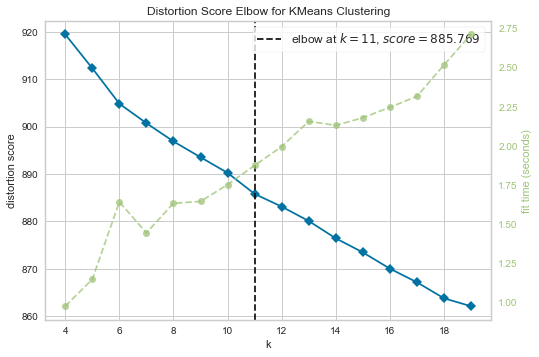

In [31]:
viz_before = vizualize_elbow(matrix_before)
viz_before.show()

In [71]:
number_of_clusters=11
km_before = KMeans(n_clusters=number_of_clusters, random_state=1)
model_before = km_before.fit(matrix_before)

In [73]:
pkl_filename = "pickle_model_before.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(model_before, file)

# Load from file
with open(pkl_filename, 'rb') as file:
    pickle_model = pickle.load(file)

Let's have an overview of our clusters' centers (centroids) and labels. Then we get the top 20 terms for every cluster. In other words, we see which are the most frequently mentioned words per cluster. Note that since we have applied Stemming, we only have the "root" of the words now.

In [34]:
centroids_before, labels_before = km_before.cluster_centers_, km_before.labels_
print(labels_before)

[10  8  5 ...  2  8  9]


In [35]:
print("Top terms per cluster:")
order_centroids_before = centroids_before.argsort()[:, ::-1]
terms = vec_before.get_feature_names()
for i in range(number_of_clusters):
    top_words = [terms[ind] for ind in order_centroids_before[i, :20]]
    print("Cluster {}: {}".format(i, ' '.join(top_words)))

Top terms per cluster:
Cluster 0: infect respiratori virus viral diseas viru exacerb develop immun rhinoviru respons host human tract caus role review associ life acut
Cluster 1: airway cell inflamm infect mice respons epitheli increas exacerb hyperrespons bronchial viral induc cytokin remodel subject express eosinophil inflammatori allerg
Cluster 2: exacerb copd trigger exposur infect diseas health factor viral air respiratori increas review allergi risk chronic treatment current patient virus
Cluster 3: pneumonia rvc children infect patient clinic respiratori atyp exacerb ari mycoplasma bacteri pathogen acut chlamydia sever influenza diagnosi present group
Cluster 4: bronchiol rsv children wheez infant respiratori hospit age recurr infect rhinoviru month viru caus year syncyti develop risk viral sever
Cluster 5: diseas cell lung activ protein express pulmonari function gene inflammatori receptor role chronic regul macrophag drug therapeut immun infect human
Cluster 6: hrv hrvc infect

PCA and its implementation in Python:
https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html

In [36]:
T_before = preprocessing.Normalizer().fit_transform(df_before)

# Fit and transform the TFidf values to PCA
pca_model = PCA(n_components=2, random_state = 2)
pca_model.fit(T_before) 
T_before = pca_model.transform(T_before)

#Transform the centroids
centroids_before_pca = pca_model.transform(centroids_before)

In [37]:
type(centroids_before_pca)

numpy.ndarray

In [38]:
centroids_before_df = pd.DataFrame(centroids_before_pca, columns = ['dimension 1','dimension 2'])
centroids_before_df

dimension 1  dimension 2
0      0.032747     0.183614
1     -0.140822     0.109566
2     -0.054945     0.060767
3      0.077436    -0.048141
4      0.179379    -0.006383
5     -0.180463     0.015265
6      0.104494     0.058065
7      0.008456    -0.030290
8     -0.045281    -0.115358
9      0.154985     0.009037
10     0.180354    -0.018304

In [39]:
centroids_before_df["pca_1"] = centroids_before_pca[:,0]
centroids_before_df["pca_2"] = centroids_before_pca[:,1]
centroids_before_df

dimension 1  dimension 2     pca_1     pca_2
0      0.032747     0.183614  0.032747  0.183614
1     -0.140822     0.109566 -0.140822  0.109566
2     -0.054945     0.060767 -0.054945  0.060767
3      0.077436    -0.048141  0.077436 -0.048141
4      0.179379    -0.006383  0.179379 -0.006383
5     -0.180463     0.015265 -0.180463  0.015265
6      0.104494     0.058065  0.104494  0.058065
7      0.008456    -0.030290  0.008456 -0.030290
8     -0.045281    -0.115358 -0.045281 -0.115358
9      0.154985     0.009037  0.154985  0.009037
10     0.180354    -0.018304  0.180354 -0.018304

In [40]:
asthma_before_covid['Labels'] = km_before.labels_
asthma_before_covid['pca_1'] = T_before[:, 0]
asthma_before_covid['pca_2'] = T_before[:, 1]

In [41]:
asthma_before_covid = asthma_before_covid.sort_values(by = "Labels", ascending = True)

In [42]:
asthma_before_covid['Labels'] = asthma_before_covid['Labels'].astype(str)

In [43]:
asthma_before_covid['Labels'].value_counts().sort_values(ascending=True)

7      27
4      37
6      38
3      40
9      73
1      79
0      88
2      90
10    144
5     146
8     258
Name: Labels, dtype: int64

Finally, let's plot the clusters!

In [44]:
fig_clusters_before = px.scatter(asthma_before_covid, 
                 x="pca_1", 
                 y="pca_2", 
                 color="Labels",
                 hover_data=['title'])

fig_clusters_before.show()

Having a look at the clusters, we assing labels to them so that we can easily get a sense of each cluster's topic!

In [45]:
centroids_before_titles = ["Immune response", 
                           "Molecular links",
                           "Asthma and COPD exacerbations",
                           "title4",
                           "title5",                           
                           "title6",
                           "title7",                           
                           "title8",
                           "title9",
                           "title10",
                           "title11"]

In [46]:
centroids_before_df["centroids_labels"] = centroids_before_titles
centroids_before_df

dimension 1  dimension 2     pca_1     pca_2  \
0      0.032747     0.183614  0.032747  0.183614   
1     -0.140822     0.109566 -0.140822  0.109566   
2     -0.054945     0.060767 -0.054945  0.060767   
3      0.077436    -0.048141  0.077436 -0.048141   
4      0.179379    -0.006383  0.179379 -0.006383   
5     -0.180463     0.015265 -0.180463  0.015265   
6      0.104494     0.058065  0.104494  0.058065   
7      0.008456    -0.030290  0.008456 -0.030290   
8     -0.045281    -0.115358 -0.045281 -0.115358   
9      0.154985     0.009037  0.154985  0.009037   
10     0.180354    -0.018304  0.180354 -0.018304   

                               centroids_labels  
0   Airway cells'components and immune response  
1                                       title 1  
2                                        title2  
3                                        title3  
4                                        title4  
5                                        title5  
6                                        title6  
7                                        title7  
8                                        title8  
9                                        title9  
10                                      title10

In [47]:
fig_clusters_before.add_scatter(y=centroids_before_df["pca_2"].tolist(),
                         x=centroids_before_df["pca_1"].tolist(),
                         mode="markers+text",
                         text=centroids_before_df["centroids_labels"],
                         marker=dict(size=10, color="white"),
                         name="Centroids")

In [48]:
fig_clusters_before.update_layout(
    title_text='Asthma and various coronaviruses',
    legend=dict(
        font=dict(
            size=15)))

Below, we also get the number of features, in our case the number of papers that each cluster contains.

In [49]:
asthma_before_covid['Labels'].value_counts().sort_values(ascending=False)

8     258
5     146
10    144
2      90
0      88
1      79
9      73
3      40
6      38
4      37
7      27
Name: Labels, dtype: int64

### After covid-19

The exact same process is followed for the groups of papers published after the SARS-CoV-2 outbreak.

In [50]:
texts_after = asthma_after_covid["abstract_lower"].tolist()

In [51]:
vec_after = TfidfVectorizer(tokenizer=custom_tokenizer,
                      stop_words='english', 
                           max_features=1000)

matrix_after = vec_after.fit_transform(texts_after)
df_after = pd.DataFrame(matrix_after.toarray(), columns=vec_after.get_feature_names())

c:\users\katerina\appdata\local\programs\python\python37\lib\site-packages\sklearn\feature_extraction\text.py:386: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['cri', 'describ', 'sincer'] not in stop_words.



In [52]:
df_after.head()

abil  abl  abnorm  absenc  abstract  access    accord   account  accumul  \
0   0.0  0.0     0.0     0.0  0.094478     0.0  0.084787  0.093524      0.0   
1   0.0  0.0     0.0     0.0  0.000000     0.0  0.000000  0.000000      0.0   
2   0.0  0.0     0.0     0.0  0.000000     0.0  0.000000  0.000000      0.0   
3   0.0  0.0     0.0     0.0  0.000000     0.0  0.000000  0.000000      0.0   
4   0.0  0.0     0.0     0.0  0.000000     0.0  0.000000  0.000000      0.0   

   achiev  ...     world  worldwid  wors  worsen  wuhan      year  york  \
0     0.0  ...  0.080312       0.0   0.0     0.0    0.0  0.152950   0.0   
1     0.0  ...  0.000000       0.0   0.0     0.0    0.0  0.000000   0.0   
2     0.0  ...  0.000000       0.0   0.0     0.0    0.0  0.076022   0.0   
3     0.0  ...  0.000000       0.0   0.0     0.0    0.0  0.000000   0.0   
4     0.0  ...  0.000000       0.0   0.0     0.0    0.0  0.000000   0.0   

      young  younger  youth  
0  0.101638      0.0    0.0  
1  0.000000      0.0    0.0  
2  0.000000      0.0    0.0  
3  0.000000      0.0    0.0  
4  0.000000      0.0    0.0  

[5 rows x 1000 columns]

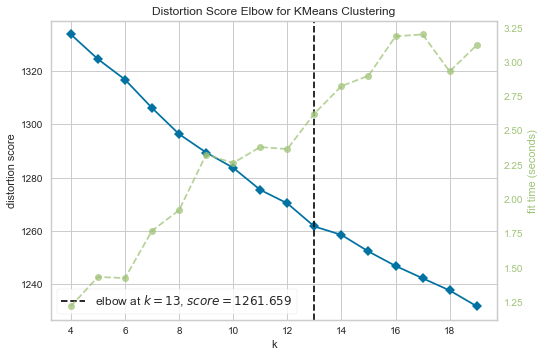

In [53]:
viz_after = vizualize_elbow(matrix_after)
viz_after.show()

In [54]:
number_of_clusters=12
km_after = KMeans(n_clusters=number_of_clusters, random_state=1)
km_after.fit(matrix_after)

KMeans(n_clusters=12, random_state=1)

In [55]:
centroids_after, labels_after = km_after.cluster_centers_, km_after.labels_
print(centroids_after)

[[0.00166386 0.         0.         ... 0.00209852 0.00838133 0.        ]
 [0.00135505 0.00093547 0.00644738 ... 0.00891057 0.01742926 0.00420432]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.00512729 0.         ... 0.         0.         0.        ]
 [0.00238459 0.00133899 0.         ... 0.00374146 0.00595813 0.00213871]
 [0.00049032 0.00300463 0.         ... 0.00108853 0.00195224 0.04011032]]


In [56]:
print("Top terms per cluster:")
order_centroids_after = km_after.cluster_centers_.argsort()[:, ::-1]
terms = vec_after.get_feature_names()
for i in range(number_of_clusters):
    top_ten_words = [terms[ind] for ind in order_centroids_after[i, :20]]
    print("Cluster {}: {}".format(i, ' '.join(top_ten_words)))

Top terms per cluster:
Cluster 0: ci patient hospit risk associ icu diseas mortal hr age factor copd death adjust admiss adult studi outcom higher peopl
Cluster 1: children pediatr patient infect hospit respiratori year age sever admiss studi clinic symptom vs diseas test includ risk wheez pandem
Cluster 2: women pregnant matern pregnanc sever case neonat diseas infect deliveri death moder birth obes risk patient ci hospit higher outcom
Cluster 3: express cell gene airway epitheli copd receptor bronchial allerg upregul infect level sever diseas blood associ entri increas protein factor
Cluster 4: patient care pandem treatment biolog allergi telemedicin provid drug recommend therapi diseas allerg manag clinic sever medicin current practic evid
Cluster 5: patient respiratori infect diseas sever corticosteroid coronaviru inhal pandem exacerb risk treatment symptom acut control use caus chronic lung syndrom
Cluster 6: patient hospit sever comorbid diseas risk outcom age studi mortal higher

In [57]:
order_centroids_after

array([[146, 634, 403, ..., 476, 490, 499],
       [142, 638, 634, ..., 897, 119, 708],
       [987, 677, 532, ..., 546, 545,   0],
       ...,
       [ 37, 663, 389, ..., 543, 542,   0],
       [264, 792, 830, ..., 133, 790, 799],
       [389, 240, 649, ..., 628, 886, 841]], dtype=int64)

In [58]:
T_after = preprocessing.Normalizer().fit_transform(df_after)

# Dimesionality reduction to 2
pca_model = PCA(n_components=2, random_state=2)
pca_model.fit(T_after) 
T_after = pca_model.transform(T_after) 

#Transform the cluster's centroids
centroids_after_pca = pca_model.transform(centroids_after)

In [59]:
asthma_after_covid['Labels'] = km_after.labels_
asthma_after_covid['pca_1'] = T_after[:, 0]
asthma_after_covid['pca_2'] = T_after[:, 1]

In [60]:
centroids_after_df = pd.DataFrame(centroids_after_pca, columns = ['dimension 1','dimension 2'])
centroids_after_df

dimension 1  dimension 2
0      0.174134     0.075410
1      0.052650    -0.185306
2      0.121374     0.021314
3     -0.177470     0.211345
4     -0.051865    -0.094051
5     -0.028367     0.018893
6      0.214602     0.082749
7     -0.193962     0.067677
8      0.065744    -0.049713
9     -0.101879    -0.111240
10     0.035770     0.035199
11    -0.012620    -0.076946

In [61]:
centroids_after_df["pca_1"] = centroids_after_pca[:,0]
centroids_after_df["pca_2"] = centroids_after_pca[:,1]
centroids_after_df

dimension 1  dimension 2     pca_1     pca_2
0      0.174134     0.075410  0.174134  0.075410
1      0.052650    -0.185306  0.052650 -0.185306
2      0.121374     0.021314  0.121374  0.021314
3     -0.177470     0.211345 -0.177470  0.211345
4     -0.051865    -0.094051 -0.051865 -0.094051
5     -0.028367     0.018893 -0.028367  0.018893
6      0.214602     0.082749  0.214602  0.082749
7     -0.193962     0.067677 -0.193962  0.067677
8      0.065744    -0.049713  0.065744 -0.049713
9     -0.101879    -0.111240 -0.101879 -0.111240
10     0.035770     0.035199  0.035770  0.035199
11    -0.012620    -0.076946 -0.012620 -0.076946

In [62]:
asthma_after_covid = asthma_after_covid.sort_values(by = "Labels", ascending = True)

In [63]:
asthma_after_covid['Labels'] = asthma_after_covid['Labels'].astype(str)

In [64]:
fig_clusters_after = px.scatter(asthma_after_covid, 
                 x="pca_1", 
                 y="pca_2", 
                 color="Labels",
                 hover_data=['title'])

fig_clusters_after.show()

Labels are assigned to thig group of clusters as well

In [65]:
centroids_after_titles = ["title 1", "title2", "title3", "title4","title5", "title6", "title7","title8","title9","title10", "title 12", "title13"]


In [66]:
centroids_after_df["centroids_labels"] = centroids_after_titles
centroids_after_df

dimension 1  dimension 2     pca_1     pca_2 centroids_labels
0      0.174134     0.075410  0.174134  0.075410          title 1
1      0.052650    -0.185306  0.052650 -0.185306           title2
2      0.121374     0.021314  0.121374  0.021314           title3
3     -0.177470     0.211345 -0.177470  0.211345           title4
4     -0.051865    -0.094051 -0.051865 -0.094051           title5
5     -0.028367     0.018893 -0.028367  0.018893           title6
6      0.214602     0.082749  0.214602  0.082749           title7
7     -0.193962     0.067677 -0.193962  0.067677           title8
8      0.065744    -0.049713  0.065744 -0.049713           title9
9     -0.101879    -0.111240 -0.101879 -0.111240          title10
10     0.035770     0.035199  0.035770  0.035199         title 12
11    -0.012620    -0.076946 -0.012620 -0.076946          title13

In [67]:
fig_clusters_after.add_scatter(y=centroids_after_df["pca_2"].tolist(),
                         x=centroids_after_df["pca_1"].tolist(),
                         mode="markers+text",
                         text=centroids_after_df["centroids_labels"],
                         marker=dict(size=10, color="white"),
                         name="Centroids")

In [68]:
fig_clusters_after.update_layout(
    title_text='Asthma and SARS-CoV-2',
    legend=dict(
        font=dict(
            size=15)))

In [69]:
asthma_after_covid['Labels'].value_counts().sort_values(ascending=False)

7     252
10    188
4     184
8     152
5     145
6     140
1     129
0     115
11     67
3      55
9      46
2      35
Name: Labels, dtype: int64